### Libraries

In [6]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import List, Tuple


## Utils functions

In [23]:

def evaluate_policy(env, q_table, episodes=10):
    """Evaluate the Q-learning agent for a certain number of episodes and return average reward and steps."""
    total_reward, total_length = 0, 0

    for _ in range(episodes):
        state = env.reset()[0]
        done = truncated = False
        episode_reward, steps = 0, 0

        while not (done or truncated):
            action = np.argmax(q_table[state])
            state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            if steps >200:
                episode_reward = 0
                print("eval break")
                break

        total_reward += episode_reward
        total_length += steps

    avg_reward = total_reward / episodes
    avg_length = total_length / episodes
    return avg_reward, avg_length


def _plot_evaluation(rewards: List[float], lengths: List[int]):
    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title("Average Cumulative Reward vs. Evaluation Episodes")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Cumulative Reward")

    plt.subplot(1, 2, 2)
    plt.plot(lengths)
    plt.title("Average Steps vs. Evaluation Episodes")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Steps")
    plt.tight_layout()
    plt.show()


def visualize_frozen_lake(q_table, env_name="FrozenLake-v1"):
    """Visualize Frozen lake

    Args:
        q_table (_type_): learning rates
        env_name (str, optional): _description_. Defaults to "FrozenLake-v1".
    """
    env = gym.make(env_name, render_mode="human")
    state = env.reset()[0]
    env.render()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, truncated, info = env.step(action)
        total_reward += reward
        env.render()
        print(f"Action: {action}, State: {state}, Reward: {reward}")
        if done:
            print(f"Episode finished with a total reward of: {total_reward}")


def visualize_frozen_lake_double(q_table_a, q_table_b, env_name="FrozenLake-v1"):
    env = gym.make(env_name, render_mode="human", is_slippery=False)
    state = env.reset()[0]
    env.render()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(
            (q_table_a[state] + q_table_b[state]) / 2
        )  # Use the average of both Q-tables
        state, reward, done, truncated, info = env.step(action)
        total_reward += reward
        env.render()
        print(f"Action: {action}, State: {state}, Reward: {reward}")
        if done:
            print(f"Episode finished with a total reward of: {total_reward}")

def universal_initialize_q_table(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q_table = np.random.uniform(low=-0.1, high=0.1, size=(n_states, n_actions))
    q_table[(env.desc == b"G").flatten()] = 0 
    return q_table

## Environment Creation

In [24]:
# Create the FrozenLake environment
env = gym.make("FrozenLake-v1", is_slippery=False)

## Train Q-learning

In [25]:
def train_q_learing(
    env: gym.Env,
    alpha: float = 0.1,
    gamma: float = 0.99,
    initial_epsilon: float = 1.0,
    min_epsilon: float = 0.01,
    epsilon_decay: float = 0.995,
    episodes: int = 20000,
    eval_every: int = 100,
    eval_episodes: int = 20,
) -> Tuple:
    """Trains an agent using the Q-learning algorithm on a specified environment.

    This function initializes a Q-table with random values and iteratively updates it based on the agent's experiences in the environment. The exploration rate (epsilon) decreases over time, allowing the agent to transition from exploring the environment to exploiting the learned Q-values. The function periodically evaluates the agent's performance using the current Q-table and returns the training history.

    Args:
        env (gym.Env): The environment to train the agent on. Must be compatible with the OpenAI Gym interface.
        alpha (float): The learning rate, determining how much of the new Q-value estimate to use. Defaults to 0.1.
        gamma (float): The discount factor, used to balance immediate and future rewards. Defaults to 0.99.
        initial_epsilon (float): The initial exploration rate, determining how often the agent explores random actions. Defaults to 1.0.
        min_epsilon (float): The minimum exploration rate after decay. Defaults to 0.01.
        epsilon_decay (float): The factor used for exponential decay of epsilon. Defaults to 0.995.
        episodes (int): The total number of episodes to train the agent for. Defaults to 10000.
        eval_every (int): The frequency (in episodes) at which to evaluate the agent's performance. Defaults to 100.
        eval_episodes (int): The number of episodes to use for each evaluation. Defaults to 10.

    Returns:
        tuple: A tuple containing three elements:
            - np.ndarray: The final Q-table learned by the agent.
            - list: A history of average rewards obtained by the agent during evaluation periods.
            - list: A history of average step lengths taken by the agent during evaluation periods.

    """
    # Initialize Q-table
    # n_states = env.observation_space.n
    # n_actions = env.action_space.n
    # q_table = np.random.uniform(low=-0.1, high=0.1, size=(n_states, n_actions))
    # q_table[(env.desc == b"G").flatten()] = 0  # Assuming 'G' is the goal/terminal state
    q_table = universal_initialize_q_table(env)
    env.reset(seed=1234)
    epsilon = initial_epsilon
    rewards, lengths = [], []

    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        truncated = False
        total_reward, steps = 0, 0

        while not (done or truncated):
            # Epsilon-greedy action selection
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore action space
            else:
                action = np.argmax(q_table[state, :])  # Exploit learned values

            next_state, reward, done, truncated, info = env.step(action)

            # Q-Learning update rule
            q_table[state, action] = q_table[state, action] + alpha * (
                reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action]
            )
            total_reward += reward

            state = next_state

            steps += 1

        # Epsilon decay
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Evaluation
        if (episode + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(env, q_table, eval_episodes)
            rewards.append(avg_reward)
            lengths.append(avg_length)
            # print(f"Episode: {episode + 1}, Avg. Reward: {avg_reward}, Avg. Length: {avg_length}, Epsilon: {epsilon}")

    print("Training completed.")
    return q_table, rewards, lengths


Training completed.


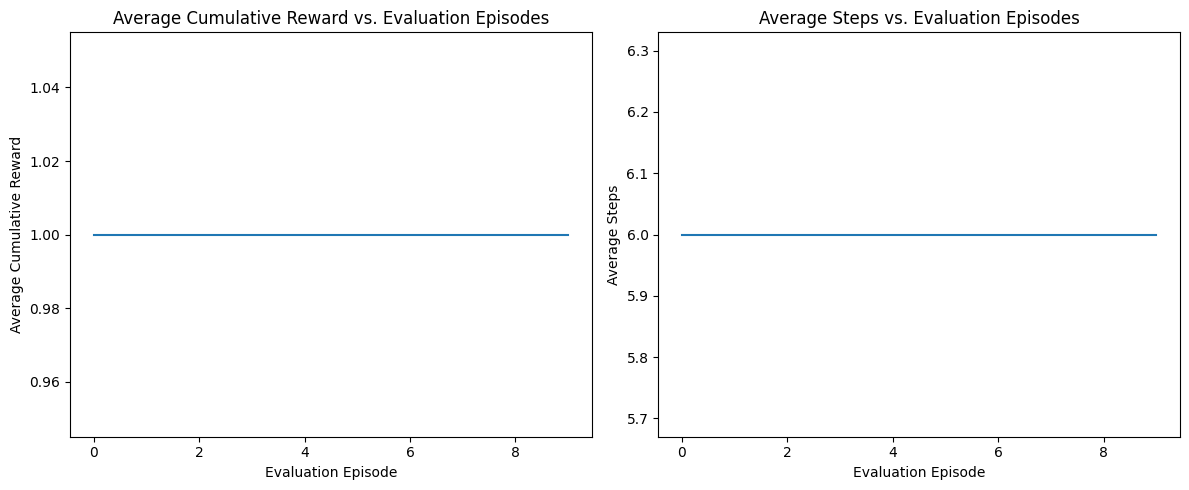

[[ 0.90541183  0.80921487  0.95099005  0.91275367]
 [ 0.90347749  0.03938581  0.96059601  0.94379146]
 [ 0.93589299  0.970299    0.8968998   0.90818549]
 [ 0.95113742  0.00765429  0.04960279  0.06379906]
 [ 0.06794495  0.06798896  0.03938965  0.91442901]
 [ 0.01226295  0.02689442 -0.06315979  0.03978445]
 [ 0.03917761  0.9801      0.01533945  0.9291544 ]
 [ 0.01547765 -0.0948935   0.00857636 -0.02239033]
 [ 0.05453523  0.03655846  0.0570667   0.06803862]
 [ 0.07463134  0.00130418  0.93548618  0.05786227]
 [ 0.78814069  0.99        0.05965085  0.93615443]
 [ 0.06241537 -0.00377578 -0.02461736 -0.0220794 ]
 [ 0.05788798  0.00994912 -0.06785945  0.05775735]
 [ 0.04755719  0.10195894  0.95259477  0.02078003]
 [ 0.81581512  0.98125944  1.          0.95717445]
 [ 0.          0.          0.          0.        ]]


In [26]:
# Train the agent using Standard Q learning
q_table, rewards, lengths = train_q_learing(env, episodes=10000, eval_episodes=1000, eval_every=1000)
_plot_evaluation(rewards, lengths)
print(q_table)
# visualize_frozen_lake(q_table)

## Train DQL

In [27]:
def train_double_q_learning(
    env: gym.Env,
    alpha: float = 0.1,
    gamma: float = 0.99,
    initial_epsilon: float = 1.0,
    min_epsilon: float = 0.1,
    epsilon_decay: float = 0.995,
    episodes: int = 20000,
    eval_every: int = 100,
    eval_episodes: int = 20,
) -> Tuple[np.ndarray, np.ndarray, List[float], List[int]]:
    """
    Trains an agent using the Double Q-learning algorithm on a specified environment.

    Args:
        env (gym.Env): The environment to train the agent on.
        alpha (float): Learning rate.
        gamma (float): Discount factor for future rewards.
        initial_epsilon (float): Starting value for epsilon in the epsilon-greedy strategy.
        min_epsilon (float): Minimum value that epsilon can decay to over time.
        epsilon_decay (float): Rate at which epsilon decays after each episode.
        episodes (int): Total number of training episodes.
        eval_every (int): Frequency of evaluation phases during training.
        eval_episodes (int): Number of episodes to run during each evaluation phase.

    Returns:
        Tuple[np.ndarray, np.ndarray, List[float], List[int]]: A tuple containing:
            - The final Q-table A learned by the agent.
            - The final Q-table B learned by the agent.
            - A history of average rewards obtained during evaluation periods.
            - A history of average step lengths taken during evaluation periods.
    """
    # n_states = env.observation_space.n
    # n_actions = env.action_space.n
    # q_table_a = np.random.uniform(low=0, high=0.1, size=(n_states, n_actions))
    # q_table_b = np.random.uniform(low=0, high=0.1, size=(n_states, n_actions))
    # q_table_a[
    #     (env.desc == b"G").flatten()
    # ] = 0  # Assuming 'G' is the goal/terminal state
    # q_table_b[
    #     (env.desc == b"G").flatten()
    # ] = 0  # Assuming 'G' is the goal/terminal state

    q_table_a = universal_initialize_q_table(env)
    q_table_b = universal_initialize_q_table(env)

    epsilon = initial_epsilon
    rewards, lengths = [], []
    env.reset(seed=1234)
    max_steps = 99

    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        truncated = False
        total_reward, steps = 0, 0
        broke = False

        for step in range(max_steps):
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table_a[state, :] + q_table_b[state, :])

            next_state, reward, done, truncated, info = env.step(action)
            if np.random.rand() < 0.5:
                best_next_action = np.argmax(q_table_a[next_state, :])
                td_target = reward + gamma * q_table_b[next_state, best_next_action]
                q_table_a[state, action] += alpha * (
                    td_target - q_table_a[state, action]
                )
            else:
                best_next_action = np.argmax(q_table_b[next_state, :])
                td_target = reward + gamma * q_table_a[next_state, best_next_action]
                q_table_b[state, action] += alpha * (
                    td_target - q_table_b[state, action]
                )

            total_reward += reward
            steps += 1
            state = next_state
            # If done (if we're dead) : finish episode
            if done:
                break
        epsilon = max(min_epsilon, epsilon_decay * epsilon)

        if (episode + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(
                env, q_table_a + q_table_b, eval_episodes
            )
            rewards.append(avg_reward)
            lengths.append(avg_length)

    print("Double Q-learning training completed.")
    return q_table_a, q_table_b, rewards, lengths


Double Q-learning training completed.


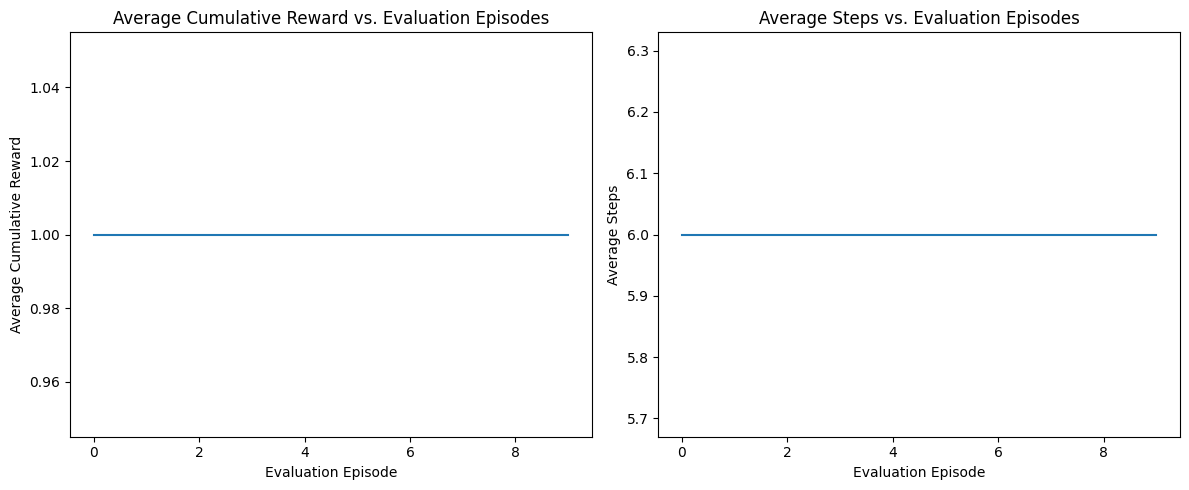

[[ 9.41472445e-01  9.50990050e-01  9.32011899e-01  9.41479806e-01]
 [ 9.41473035e-01 -5.80888865e-02 -1.92116030e-03  1.44917969e-01]
 [-3.46519394e-02 -4.98885333e-03  3.53067716e-02 -3.53581570e-02]
 [-4.65716706e-02  4.89515270e-02  3.48568986e-02  2.73658621e-02]
 [ 9.50984882e-01  9.60596010e-01 -5.82769685e-02  9.41475265e-01]
 [-4.31921039e-02  8.26991485e-03  7.36284412e-02  1.41609930e-02]
 [-5.95629712e-02 -2.95344707e-02  6.65275639e-02 -7.65948594e-03]
 [-9.06411197e-02  8.92897589e-02 -9.04310084e-02 -4.96987290e-03]
 [ 9.60595761e-01 -4.47249664e-02  9.70299000e-01  9.50987835e-01]
 [ 9.60594078e-01  9.80100000e-01  9.80065580e-01 -5.82769652e-02]
 [ 4.23889490e-01  9.90000000e-01  5.86640975e-02 -6.57666204e-03]
 [ 8.47329293e-04  2.73623818e-02 -3.35032426e-02  3.39705423e-02]
 [-2.23640557e-02  8.00691383e-02  7.74522169e-02  6.74095368e-02]
 [-4.47250087e-02  9.80086235e-01  9.90000000e-01  9.70292947e-01]
 [ 9.80069682e-01  9.89988174e-01  1.00000000e+00  9.80064406e

In [34]:
# Train the agent using Double Q learning
q_table_a, q_table_b, rewards, lengths = train_double_q_learning(env, episodes=10000, eval_episodes=1000, eval_every=1000)
_plot_evaluation(rewards, lengths)
print(q_table_a)
# visualize_frozen_lake_double(q_table_a, q_table_b)
print("Trained Q-Table:")
print(q_table_a)
print("Trained Q-Table:")
print(q_table_b)

## Train SQL

In [79]:

def initialize_q_tables(state_space, action_space):
    """Initialize Q-tables Q_0 and Q_{-1}."""
    Q_0 = np.zeros((state_space, action_space))
    Q_minus_1 = np.copy(Q_0)  # Initially, Q_{-1} is the same as Q_0
    return Q_0, Q_minus_1

def epsilon_greedy_policy(Q, state, epsilon):
    """Choose an action based on epsilon-greedy policy."""
    if np.random.random() < epsilon:
        return np.random.randint(Q.shape[1])
    else:
        return np.argmax(Q[state])

def asynchronous_speedy_q_learning(
        env, alpha=0.1, epsilon=1.0, gamma=0.99, total_time_steps=10000,
        eval_every: int = 100,
        eval_episodes: int = 10
):
    state_space = env.observation_space.n
    action_space = env.action_space.n

    # Initialize Q-tables and state visit counts
    Q_k, Q_k_minus_1 = initialize_q_tables(state_space, action_space)
    # Q_k = universal_initialize_q_table(env)
    # Q_k_minus_1 = np.copy(Q_k)
    k = 0  # Iteration counter
    N = np.zeros((state_space, action_space), dtype=int)
    state = env.reset()[0]
    t = 0
    rewards, lengths = [], []
    total_reward, steps = 0, 0
    lake_map=env.desc
    frozen_lake_binary = np.array(( (lake_map != b'H') & (lake_map != b'G')).astype(int).flatten())
    # print(frozen_lake_binary)
    hole_indeces = np.where(frozen_lake_binary==0)[0]
    print(hole_indeces)
    while t <= total_time_steps:
        action = epsilon_greedy_policy(Q_k, state, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        # Update visit count

        N[state][action] += 1
        eta = 1 / N[state][action]

        # Compute temporal differences
        best_next_action_k_minus_1 = np.argmax(Q_k_minus_1[next_state])
        best_next_action_k = np.argmax(Q_k[next_state])
        T_kQ_k_minus_1 = (1 - eta) * Q_k_minus_1[state, action] + eta * (reward + gamma * Q_k_minus_1[next_state, best_next_action_k_minus_1])
        T_kQ_k = (1 - eta) * Q_k[state, action] + eta * (reward + gamma * Q_k[next_state, best_next_action_k])

        # Update Q_k+1
        Q_k_plus_1 = (1 - alpha) * Q_k[state, action] + alpha * (k * T_kQ_k - (k-1) * T_kQ_k_minus_1)

        # Update Q-table references
        Q_k_minus_1 = Q_k
        Q_k[state, action] = Q_k_plus_1
        total_reward += reward
        steps += 1
        # Move to next state
        state = next_state

        # Check if all state-action pairs have been visited
        if np.min(N[hole_indeces]) > 0:
            print("N got reset")
            k += 1
            alpha = 1 / (k + 1)
            N = np.zeros_like(N)  # Reset visit counts

            # check kon ke satisfy shode ya na
            # another function to find a subset to be greater than the number of possible accessible state

        t += 1

        if done:
            state = env.reset()[0]
            total_reward, steps = 0, 0
        if (t + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(env, Q_k, eval_episodes)
            rewards.append(avg_reward)
            lengths.append(avg_length)

    return Q_k, rewards, lengths

SQL-10000steps
[ 5  7 11 12 15]


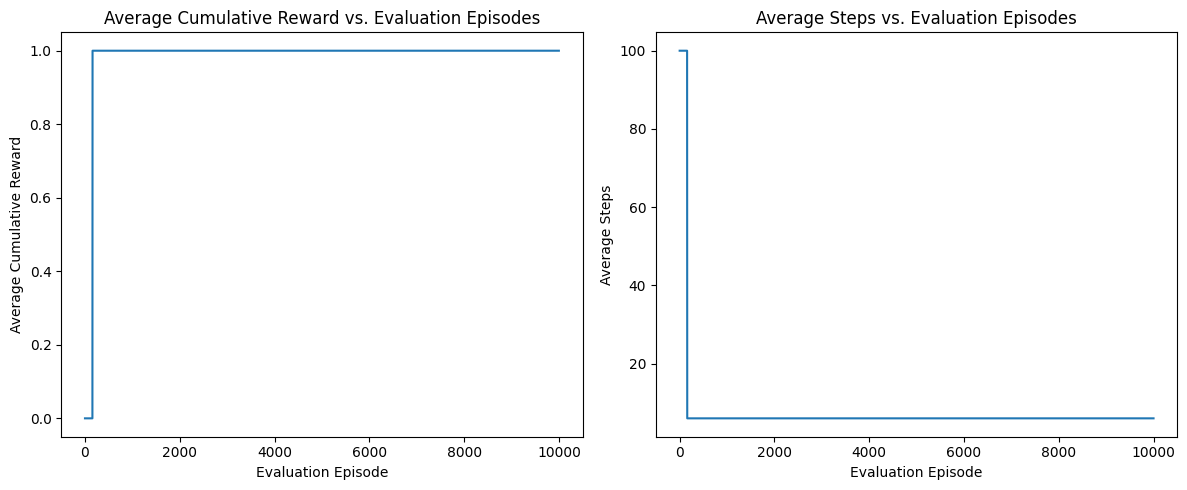

Trained Q-Table:
[[4.59931237e-07 7.13708757e-06 2.92909815e-06 4.58413869e-07]
 [4.52251978e-07 0.00000000e+00 4.64819370e-05 2.84550327e-06]
 [2.72556383e-06 6.23901512e-04 2.51113860e-06 4.15532851e-05]
 [4.25707501e-05 0.00000000e+00 2.12028071e-06 2.58552317e-06]
 [7.02065335e-06 9.22231480e-05 0.00000000e+00 4.62623497e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.70599855e-03 0.00000000e+00 4.29549345e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.77520025e-05 0.00000000e+00 9.69093467e-04 7.07746525e-06]
 [8.26403637e-05 8.17743268e-03 7.47414341e-03 0.00000000e+00]
 [7.38152945e-04 5.72726051e-02 0.00000000e+00 6.12182586e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.77974184e-03 5.76241190e-02 8.44406051e-04]
 [6.62253940e-03 5.30683372e-02 3.17225003e-01 5.53605591e-03]
 [0.00000000e+00 0.00000000e+00 0.0000

In [80]:
# Train the agent using Speedy Q Learning
print("SQL-10000steps")
q_table, rewards, lengths = asynchronous_speedy_q_learning(env, total_time_steps=100000, eval_episodes=10, eval_every=10)
_plot_evaluation(rewards, lengths)
# # visualize_frozen_lake(q_table)
print("Trained Q-Table:")
print(q_table)


# HYBRID METHODS

In [76]:

def initialize_q_tables(state_space, action_space):
    """Initialize Q-tables Q_0 and Q_{-1}."""
    Q_0 = np.zeros((state_space, action_space))
    Q_minus_1 = np.copy(Q_0)  # Initially, Q_{-1} is the same as Q_0
    return Q_0, Q_minus_1

def epsilon_greedy_policy(Q, state, epsilon):
    """Choose an action based on epsilon-greedy policy."""
    if np.random.random() < epsilon:
        return np.random.randint(Q.shape[1])
    else:
        return np.argmax(Q[state])

def asynchronous_speedy_double_q_learningI(
        env, alpha=0.1, epsilon=0.5, gamma=0.99, total_time_steps=10000,
        eval_every: int = 100,
        eval_episodes: int = 10
):
    state_space = env.observation_space.n
    action_space = env.action_space.n

    lake_map=env.desc
    frozen_lake_binary = np.array(( (lake_map != b'H') & (lake_map != b'G')).astype(int).flatten())
    # print(frozen_lake_binary)
    hole_indeces = np.where(frozen_lake_binary==0)[0]
    
    # Initialize Q-tables and state visit counts
    Q_k, Q_k_minus_1 = initialize_q_tables(state_space, action_space)
    # Q_k = universal_initialize_q_table(env)
    # Q_k_minus_1 = np.copy(Q_k)
    k = 0  # Iteration counter
    N = np.zeros((state_space, action_space), dtype=int)
    state = env.reset()[0]
    t = 0
    rewards, lengths = [], []
    total_reward, steps = 0, 0
    while t < total_time_steps - 1:
        action = epsilon_greedy_policy(Q_k, state, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        # Update visit count

        N[state][action] += 1
        eta = 1 / N[state][action]

        # Compute temporal differences
        best_next_action_k_minus_1 = np.argmax(Q_k_minus_1[next_state])
        best_next_action_k = np.argmax(Q_k[next_state])
        T_kQ_k_minus_1 = (1 - eta) * Q_k_minus_1[state, action] + eta * (reward + gamma * Q_k_minus_1[next_state, best_next_action_k])
        T_kQ_k = (1 - eta) * Q_k[state, action] + eta * (reward + gamma * Q_k[next_state, best_next_action_k_minus_1])

        # Update Q_k+1
        Q_k_plus_1 = (1 - alpha) * Q_k[state, action] + alpha * (k * T_kQ_k - (k-1) * T_kQ_k_minus_1)

        # Update Q-table references
        Q_k_minus_1 = Q_k
        Q_k[state, action] = Q_k_plus_1
        total_reward += reward
        steps += 1
        # Move to next state
        state = next_state

        # Check if all state-action pairs have been visited
        if np.min(N[hole_indeces]) > 0:
            k += 1
            alpha = 1 / (k + 1)
            N = np.zeros_like(N)  # Reset visit counts

        t += 1

        if done:
            state = env.reset()[0]
            total_reward, steps = 0, 0
        if (t + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(env, Q_k, eval_episodes)
            rewards.append(avg_reward)
            lengths.append(avg_length)

    return Q_k, rewards, lengths





SDQL I


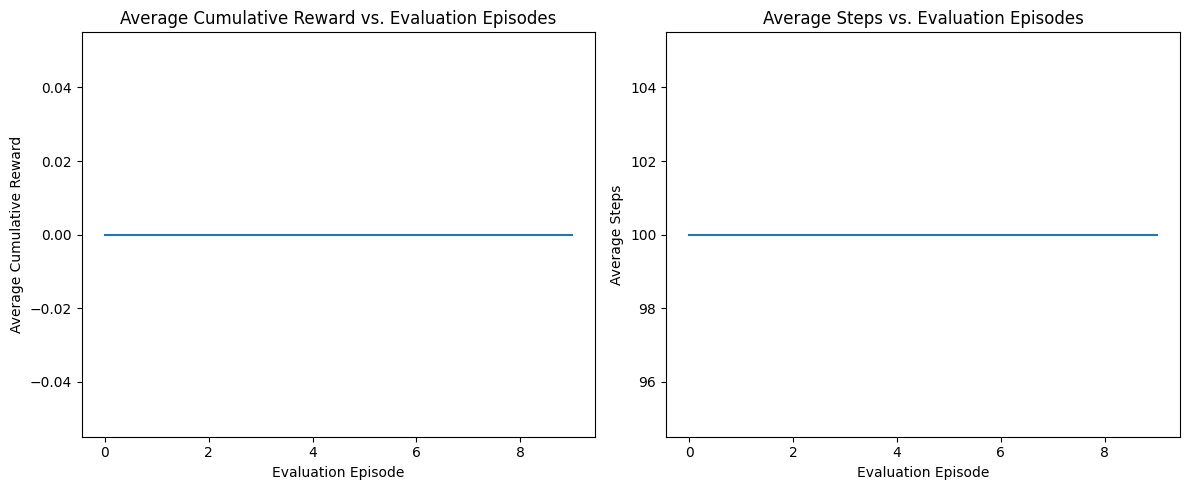

Trained Q-Table:
[[-0.0127887   0.01585519  0.07726697  0.01461081]
 [ 0.08011002  0.03356798  0.0303407   0.0441418 ]
 [ 0.04301239  0.0695037   0.05529653  0.07302516]
 [ 0.07541047 -0.00565106  0.0409009  -0.02250731]
 [ 0.06909975  0.01158077 -0.00284309  0.05847552]
 [ 0.09730989 -0.0721268   0.01307269 -0.03922183]
 [ 0.00239693  0.00377841  0.02726736  0.07669791]
 [-0.08030866  0.06962363  0.02115249 -0.04538913]
 [ 0.08661751  0.00059283 -0.00836027 -0.02406933]
 [ 0.08926101 -0.046268    0.032181    0.03323034]
 [ 0.07242964 -0.00465573  0.05995456  0.03492914]
 [ 0.07062315 -0.06633749 -0.03598557  0.00916273]
 [ 0.06609722  0.01965912 -0.00384728 -0.07174825]
 [ 0.03804262  0.02678517  0.11556907 -0.0562469 ]
 [-0.00746569 -0.01426935  0.32079089  0.09091487]
 [ 0.          0.          0.          0.        ]]


In [77]:
# Train the agent using Speedy Double Q Learning I
print("SDQL I")
q_table, rewards, lengths = asynchronous_speedy_double_q_learningI(env, total_time_steps=10000, eval_episodes=1000, eval_every=1000)
_plot_evaluation(rewards, lengths)
# # visualize_frozen_lake(q_table)
print("Trained Q-Table:")
print(q_table)


In [34]:
def initialize_q_tables(state_space, action_space):
    """ Initialize two Q-tables for Double Q-Learning with small initial values to prevent large updates initially. """
    Q_A = np.random.uniform(low=-0.5, high=0.5, size=(state_space, action_space))
    Q_B = np.random.uniform(low=-0.5, high=0.5, size=(state_space, action_space))
    return Q_A, Q_B

def epsilon_greedy_policy(Q, state, epsilon):
    """ Epsilon-greedy policy for action selection """
    if np.random.random() < epsilon:
        return np.random.randint(Q.shape[1])
    else:
        return np.argmax(Q[state])

def update_q_table(Q, Q_old,Q_2, state, action, reward, next_state, alpha, gamma, beta):
    """ Perform the Speedy Q-learning update on the chosen Q-table """
    best_next_action = np.argmax(Q[next_state])
    td_target = reward + gamma * Q_2[next_state][best_next_action]
    td_error = td_target - Q[state][action]
    Q[state][action] += alpha * td_error

    best_next_action = np.argmax(Q_old[next_state])
    td_target = reward + gamma * Q_2[next_state][best_next_action]
    td_error = td_target - Q_old[state][action]
    Q_old[state][action] += alpha * td_error

    speedy_correction = beta * (Q[state][action] - Q_old[state][action])
    Q[state][action] += speedy_correction
    return Q[state][action]

def asynchronous_speedy_double_q_learningII(env, alpha=0.05, gamma=0.99, beta=0.1, epsilon=1.0, min_epsilon=0.1, epsilon_decay=0.999, episodes=10000, eval_episodes=200, eval_every=200):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q_A, Q_B = initialize_q_tables(n_states, n_actions)
    Q_A_old, Q_B_old = Q_A.copy(), Q_B.copy()

    rewards, lengths = [], []  # Lists to store rewards and lengths of each episode
    lake_map=env.desc
    frozen_lake_binary = np.array(( (lake_map != b'H') & (lake_map != b'G')).astype(int).flatten())
    # print(frozen_lake_binary)
    hole_indeces = np.where(frozen_lake_binary==0)[0]
    
    for episode in range(episodes):
        state = env.reset()[0]
        done, truncated = False, False
        total_reward, steps = 0, 0

        while not (done or truncated):
            action = epsilon_greedy_policy((Q_A + Q_B) / 2, state, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            steps += 1

            if np.random.rand() < 0.5:
                # Update Q_A
                
                Q_A[state][action] = update_q_table(Q_A, Q_A_old, Q_B, state, action, reward, next_state, alpha, gamma, beta)
                Q_A_old[state][action] = Q_A[state][action]
            else:
                # Update Q_B
                Q_B[state][action] = update_q_table(Q_B, Q_B_old, Q_A, state, action, reward, next_state, alpha, gamma, beta)
                Q_B_old[state][action] = Q_B[state][action]

            state = next_state
        
        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Reduce epsilon
       
        if (episode + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(env, Q_A, eval_episodes)
            rewards.append(avg_reward)
            lengths.append(avg_length)


    return Q_A, Q_B, rewards, lengths


SDQL II


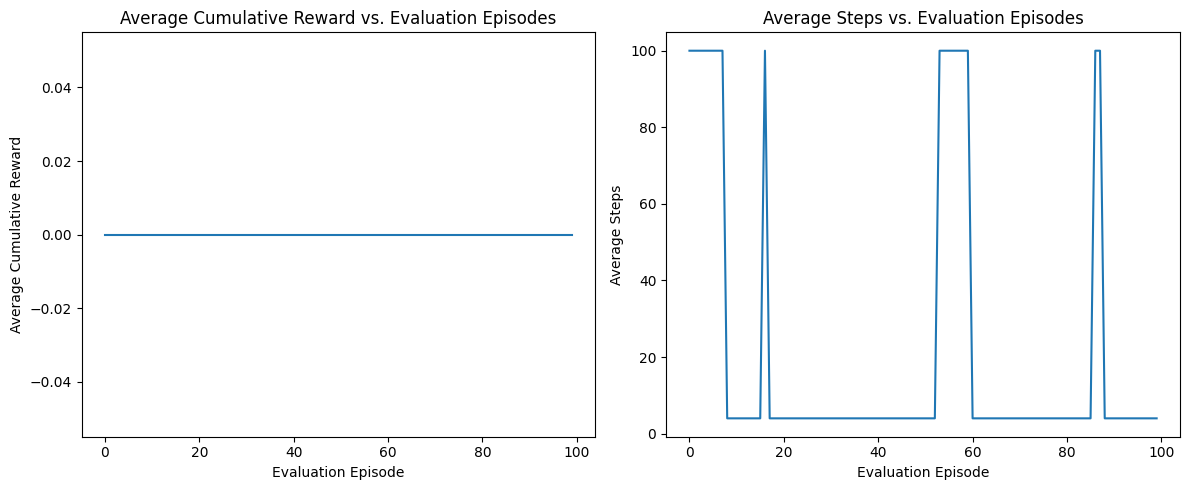

Trained Q-Table:
[[ 0.12426259  0.12183558  0.12699028  0.12423814]
 [ 0.12510263  0.07446286  0.12700765  0.12613195]
 [ 0.1266049   0.12639988  0.1295687   0.12772619]
 [ 0.12916147  0.392226    0.12958484  0.12957833]
 [-0.18214982 -0.0985449   0.07461453  0.12538929]
 [ 0.1640642  -0.42195356 -0.2554527  -0.31966587]
 [-0.00706801 -0.22279166  0.07024036  0.12846925]
 [-0.37071377  0.13219947 -0.00848344  0.29382801]
 [-0.05725622 -0.2869162  -0.36182391 -0.14858779]
 [-0.04162518 -0.17783746  0.21002958 -0.00815214]
 [-0.13609742 -0.00705155 -0.31296277  0.03882221]
 [-0.2985501  -0.25316845 -0.23409283  0.26890218]
 [-0.09357605 -0.00935952  0.35635998 -0.15672593]
 [-0.28206755 -0.10210009 -0.00162665 -0.17716985]
 [-0.07966922 -0.19120316  0.07441833 -0.11905293]
 [ 0.09258915  0.15240113 -0.06635771 -0.07289422]]


In [45]:
# Train the agent using Speedy Double Q Learning II
print("SDQL II")
q_table_a, q_table_b, rewards, lengths = asynchronous_speedy_double_q_learningII(env, episodes=10000, eval_episodes=100, eval_every=100)
_plot_evaluation(rewards, lengths)
# # visualize_frozen_lake(q_table)
print("Trained Q-Table:")
print(q_table_a)